In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random

Warning: this doesn't work. This was from Donald's code that I just changed a few things

In [48]:
def generate(string): 
    a = np.array([[1, 1, 2],[0, 1, 1],[0,-3,-2]])
    b = np.array([[-2, 0, -1],[-5, 1, -1],[3,0,1]])

    maxMats = 50
    dataPoints = 1000
    prevMat = -1


    for j in range(dataPoints):
        nextMat = random.randint(0,1)
        if nextMat == 0: 
            mat = a
            prevMat = 0
        elif nextMat == 1:
            mat = b
            prevMat = 1
        numOfMatrices = random.randint(1, maxMats)
        for i in range(numOfMatrices): 
            nextMat = random.randint(0,1)
            if (nextMat == 0):
                mat = np.matmul(a, mat)
                prevMat = nextMat
            elif (nextMat == 1):
                mat = np.matmul(b, mat)
                prevMat = nextMat
        if j == 0: 
            df = pd.DataFrame([[mat[0][0],mat[0][1],mat[0][2], mat[1][0],mat[1][1],mat[1][2],mat[2][0],mat[2][1],mat[2][2], prevMat]], columns = ['00', '01', '02','10','11','12', '20', '21','22',"last"])
        else: 
            df = pd.concat([df, pd.DataFrame([[mat[0][0],mat[0][1],mat[0][2], mat[1][0],mat[1][1],mat[1][2],mat[2][0],mat[2][1],mat[2][2], prevMat]],columns = ['00', '01', '02','10','11','12', '20', '21','22',"last"])])
# mat[0][0] = mat[0][0]  % 7
# mat [0][1] = mat[0][1]  % 7
# mat[0][2] = mat[0][2]  % 7
# mat [1][0] = mat[1][0]  % 7
# mat [1][1] = mat[1][1]  % 7
# mat [1][1] = mat[1][1]  % 7
    df.to_csv(string, index = False)

In [49]:
# code adapted from ChatGPT

# Define your neural network model
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()

        self.step1 = nn.Linear(9, 128, bias=True)
        self.step2 = nn.ReLU()
        self.step3 = nn.Linear(128, 64, bias=True)
        self.step4 = nn.ReLU()
        self.step5 = nn.Linear(64, 16, bias=True)
        self.step6 = nn.ReLU()
        self.step7 = nn.Linear(16, 2, bias=True)

        # multi-class classification adapted from ChatGPT
        self.step8 = nn.Softmax(dim=1)

    def forward(self, x):

        # RUN IT ON A GPU if it exists
        if torch.cuda.is_available():
            x = x.to("cuda")

        x = self.step1(x)
        x = self.step2(x)
        x = self.step3(x)
        x = self.step4(x)
        x = self.step5(x)
        x = self.step6(x)
        x = self.step7(x)
        x = self.step8(x)
        
        return x

def train_model(inputs, desired_outputs, num_epochs=100, learning_rate=0.01, viz_accuracy=False):
    # Convert inputs and desired_outputs to PyTorch tensors
    inputs = torch.tensor(inputs, dtype=torch.float32)
    desired_outputs = torch.tensor(desired_outputs, dtype=torch.float32)
    
    # Create a DataLoader to handle batching (if needed)
    dataset = TensorDataset(inputs, desired_outputs)
    dataloader = DataLoader(dataset, batch_size=1000, shuffle=True)  # Adjust batch_size as needed
    
    # Initialize the model
    model = SimpleModel()
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()  # Mean Squared Error loss
    # optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    # criterion = nn.MSELoss()
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)
    losses = []

    inputs = inputs.float()
    desired_outputs = desired_outputs.long()
    
    # Training loop
    for epoch in range(num_epochs):
        total_loss = 0.0
        for batch_inputs, batch_desired_outputs in dataloader:
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(batch_inputs)  # Forward pass

            batch_desired_outputs = batch_desired_outputs.long()

            loss = criterion(outputs, batch_desired_outputs)  # Compute the loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update the model's parameters
            cur_item = loss.item()
            total_loss += cur_item

        scheduler.step()
        
        # Print the average loss for this epoch
        print(f"total loss: {total_loss}")
        average_loss = total_loss / len(dataloader)
        if viz_accuracy:
            losses.append(average_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}')
    
    if viz_accuracy:
        plt.scatter(x=range(1, len(losses)+1), y=losses)
        plt.xlabel("Epoch")
        plt.ylabel("Average loss")
        plt.show()

    # Return the trained model
    return model

In [50]:
generate('matrices_train.csv')
generate('matrices_test.csv')
df = pd.read_csv("matrices_train.csv")
just_input = df.drop('last', axis=1)

# adapted from https://stackoverflow.com/questions/43898035/pandas-combine-column-values-into-a-list-in-a-new-column
input_data = np.array(just_input.values.tolist())
desired_output = torch.tensor(df['last'].tolist(), dtype=torch.float32).long()

C:\Users\16089\AppData\Local\Temp\ipykernel_24780\363369511.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  desired_outputs = torch.tensor(desired_outputs, dtype=torch.float32)


total loss: 0.7589369416236877
Epoch [1/500], Loss: 0.7589
total loss: 0.7533936500549316
Epoch [2/500], Loss: 0.7534
total loss: 0.7493364214897156
Epoch [3/500], Loss: 0.7493
total loss: 0.7549396753311157
Epoch [4/500], Loss: 0.7549
total loss: 0.7450211048126221
Epoch [5/500], Loss: 0.7450


total loss: 0.7148690223693848
Epoch [6/500], Loss: 0.7149
total loss: 0.7116102576255798
Epoch [7/500], Loss: 0.7116
total loss: 0.7116051912307739
Epoch [8/500], Loss: 0.7116
total loss: 0.6620272994041443
Epoch [9/500], Loss: 0.6620
total loss: 0.6819008588790894
Epoch [10/500], Loss: 0.6819
total loss: 0.6742511987686157
Epoch [11/500], Loss: 0.6743
total loss: 0.6791456341743469
Epoch [12/500], Loss: 0.6791
total loss: 0.6998551487922668
Epoch [13/500], Loss: 0.6999
total loss: 0.6982890963554382
Epoch [14/500], Loss: 0.6983
total loss: 0.6867495179176331
Epoch [15/500], Loss: 0.6867
total loss: 0.6712632775306702
Epoch [16/500], Loss: 0.6713
total loss: 0.6659562587738037
Epoch [17/500], Loss: 0.6660
total loss: 0.6786578297615051
Epoch [18/500], Loss: 0.6787
total loss: 0.6832034587860107
Epoch [19/500], Loss: 0.6832
total loss: 0.6653193831443787
Epoch [20/500], Loss: 0.6653
total loss: 0.6591976881027222
Epoch [21/500], Loss: 0.6592
total loss: 0.6510059237480164
Epoch [22/500

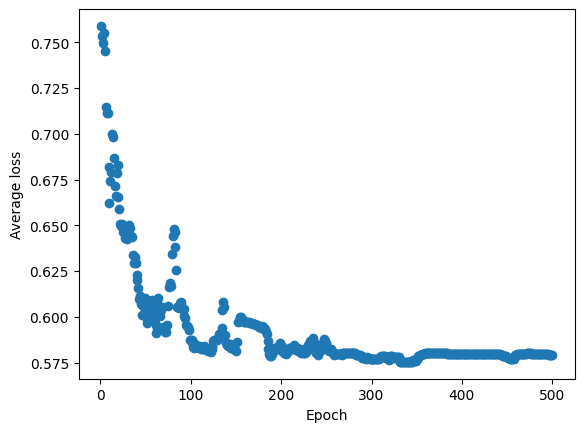

In [51]:

# Train the model
trained_model = train_model(input_data, desired_output, 500, viz_accuracy=True)


In [52]:
def test_model(trained_model, new_data, expected_result):
    test_input = torch.tensor(new_data, dtype=torch.float32)

    test_output = trained_model(test_input)
    print(test_output)

    predicted_classes = torch.argmax(test_output, dim=1)
    print(predicted_classes)

    test_output_compare = torch.tensor(expected_result, dtype=torch.int)
    print(test_output_compare)

    return float(sum(test_output_compare == predicted_classes)/len(test_input))

In [53]:
test_df = pd.read_csv("matrices_test.csv")
just_input_test = test_df.drop('last', axis=1)
input_data_test = np.array(just_input_test.values.tolist())
desired_output = torch.tensor(test_df['last'].tolist(), dtype=torch.float32).long()

test_model(trained_model, input_data_test, desired_output)

tensor([[1.0000e+00, 6.3758e-29],
        [0.0000e+00, 1.0000e+00],
        [9.9982e-01, 1.8189e-04],
        ...,
        [0.0000e+00, 1.0000e+00],
        [8.5420e-12, 1.0000e+00],
        [0.0000e+00, 1.0000e+00]], grad_fn=<SoftmaxBackward0>)
tensor([0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
        1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
        1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0,
        0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
        1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,
        0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
        0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1,
        1, 0, 0, 1, 0, 0, 1, 0, 0,

C:\Users\16089\AppData\Local\Temp\ipykernel_24780\2208809294.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_output_compare = torch.tensor(expected_result, dtype=torch.int)


0.7160000205039978